# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification


### Transfer learning

In the previous notebook we have trained our own CNN and we got a certain performance. Let's see how hard it is to match that performance with transfer learning.

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 0: Setting up

The following cells make sure that your environment is setup correctly and check that your GPU is available and ready to go. You have to execute them every time you restart your notebook.

In [1]:
# Run the installation and setup environment steps
!pip install opencv-python-headless matplotlib numpy pillow bokeh torch torchvision tqdm ipywidgets livelossplot pytest pandas seaborn

In [2]:
from src.helpers import setup_env

# If running locally, this will download dataset (make sure you have at 
# least 2 Gb of space on your hard drive)
setup_env()

GPU available
Dataset already downloaded. If you need to re-download, please delete the directory landmark_images
Reusing cached mean and std


---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 1: Create transfer learning architecture

Open the file `src/transfer.py` and complete the `get_model_transfer_learning` function. When you are done, execute this test:

In [1]:
!pytest -vv src/transfer.py

============================= test session starts ==============================
platform linux -- Python 3.9.19, pytest-8.2.2, pluggy-1.5.0 -- /home/studio-lab-user/.conda/envs/default/bin/python3.9
cachedir: .pytest_cache
rootdir: /home/studio-lab-user/sagemaker-studiolab-notebooks/workspace/home/starter-kit
plugins: anyio-4.3.0
collected 1 item                                                               

src/transfer.py::test_get_model_transfer_learning PASSED                 [100%]

============================== 1 passed in 3.17s ===============================


---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 2: Train, validation and test

Let's train our transfer learning model! Let's start defining the hyperparameters:

In [2]:
batch_size = 16  # size of the minibatch for stochastic gradient descent (or Adam)
valid_size = 0.1  # fraction of the training data to reserve for validation
num_epochs = 150  # number of epochs for training
num_classes = 50  # number of classes. Do not change this
learning_rate = 0.01  # Learning rate for SGD (or Adam)
opt = 'sgd'      # optimizer. 'sgd' or 'adam'
weight_decay = 0.0001 # regularization. Increase this to combat overfitting

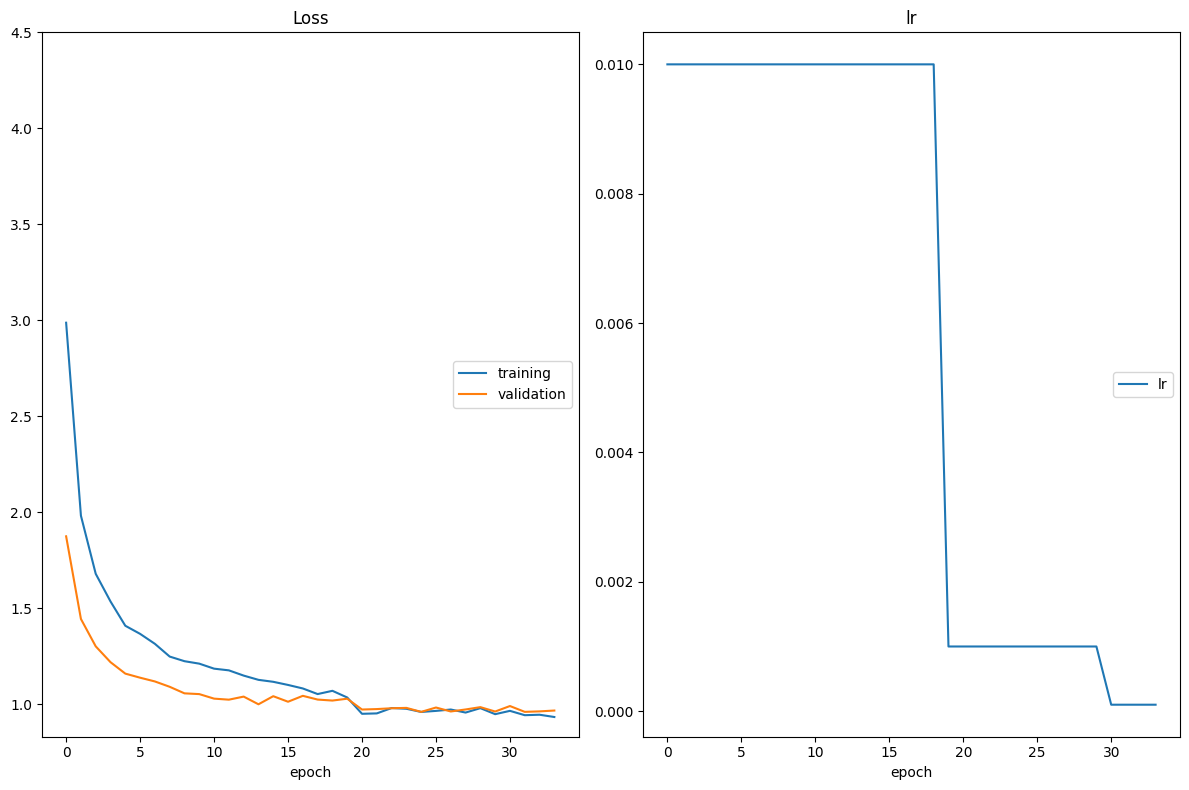

Validating: 100%|███████████████████████████████| 63/63 [00:03<00:00, 17.42it/s]


Epoch: 35 	Training Loss: 0.932058 	Validation Loss: 0.961652
EarlyStopping counter: 10 out of 10
Early stopping


In [3]:
from src.data import get_data_loaders
from src.optimization import get_optimizer, get_loss
from src.train import optimize
from src.transfer import get_model_transfer_learning

# Get a model using get_model_transfer_learning. Use one of the names reported here:
# https://pytorch.org/vision/0.10/models.html
# For example, if you want to load ResNet 18, use "resnet18"
# NOTE: use the hyperparameters defined in the previous cell, do NOT copy/paste the
# values
model_transfer = get_model_transfer_learning(model_name="resnet18", n_classes=50)

# train the model
data_loaders = get_data_loaders(batch_size=batch_size)
optimizer = get_optimizer(
    model_transfer,
    learning_rate=learning_rate,
    optimizer=opt,
    weight_decay=weight_decay,
)
loss = get_loss()

optimize(
    data_loaders,
    model_transfer,
    optimizer,
    loss,
    n_epochs=num_epochs,
    save_path="checkpoints/model_transfer.pt",
    interactive_tracking=True
)

<img src="static_images/icons/noun-question-mark-869751.png" alt="?" style="width:25px"/> __Question:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

<img src="static_images/icons/noun-answer-3361020.png" alt=">" style="width:25px"/>  __Answer:__ I decided to use ResNet18 as the base of my model due to its proven performance and efficiency. ResNet18 is known for its strong performance on the ImageNet dataset, which contains a wide variety of natural scene images, similar to the landmark classification task at hand. This alignment in data types ensures that the model is well-suited to capture and distinguish the features necessary for accurate landmark classification.

The decision to use ResNet18 was influenced by its relatively moderate size, striking a balance between computational efficiency and model complexity. This makes it feasible to train and fine-tune the model on the available hardware without compromising on performance. ResNet18's architecture, with its residual connections, helps in mitigating the vanishing gradient problem, allowing for deeper network training and better feature extraction.

Furthermore, leveraging a pre-trained ResNet18 model means starting with a network that already has a rich set of learned features from the ImageNet dataset. Fine-tuning this model for the landmark classification task allows for quicker convergence and improved performance, as the model can adapt its pre-existing features to the specifics of the new task.

Overall, the suitability of ResNet18 for this problem is underscored by its robust architecture, efficient training, and the natural scene image similarity between ImageNet and the landmark dataset. This strategic choice ensures a solid foundation for achieving high accuracy in the classification task while maintaining computational feasibility.

Now play with the hyperparameters and see which performance you can get on the validation set. You should get at least 60% for a passing grade, but a good model choice and a good training strategy could get you up to 80% or so. Let's see how close you can get!

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 3: Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60% and matches more or less what you got on the validation set (otherwise you're overfitting!)

In [4]:
import torch
from src.train import one_epoch_test
from src.transfer import get_model_transfer_learning

model_transfer = get_model_transfer_learning("resnet18", n_classes=num_classes)
# Load saved weights
model_transfer.load_state_dict(torch.load('checkpoints/model_transfer.pt'))

one_epoch_test(data_loaders['test'], model_transfer, loss)

Testing: 100%|██████████████████████████████████| 79/79 [00:04<00:00, 17.03it/s]

Test Loss: 0.907214


Test Accuracy: 76% (952/1250)


0.9072136746872735

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 4: Export using torchscript

Now, just like we did with our original model, we export the best fit model using torchscript so that it can be used in our application:

In [5]:
from src.predictor import Predictor
from src.helpers import compute_mean_and_std

# First let's get the class names from our data loaders
class_names = data_loaders["train"].dataset.classes

# Then let's move the model_transfer to the CPU
# (we don't need GPU for inference)
model_transfer = model_transfer.cpu()
# Let's make sure we use the right weights by loading the
# best weights we have found during training
# NOTE: remember to use map_location='cpu' so the weights
# are loaded on the CPU (and not the GPU)
model_transfer.load_state_dict(
    torch.load("checkpoints/model_transfer.pt", map_location="cpu")
)

# Let's wrap our model using the predictor class
mean, std = compute_mean_and_std()
predictor = Predictor(model_transfer, class_names, mean, std).cpu()

# Export using torch.jit.script
scripted_predictor = torch.jit.script(predictor)
scripted_predictor.save("checkpoints/transfer_exported.pt")

Reusing cached mean and std


100%|███████████████████████████████████████| 1250/1250 [00:50<00:00, 24.75it/s]


Accuracy: 0.7592


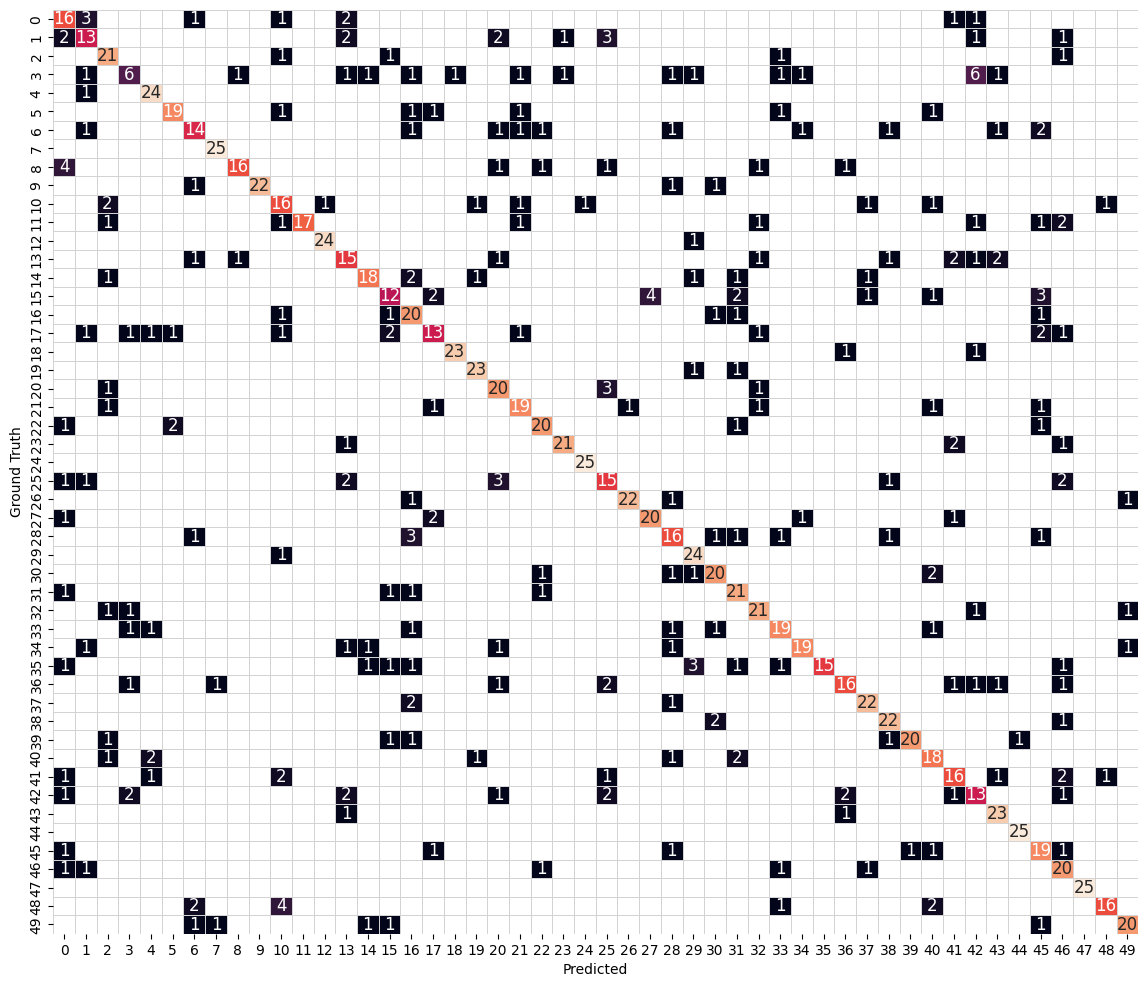

In [6]:
import torch
from src.predictor import predictor_test
from src.helpers import plot_confusion_matrix

model_reloaded = torch.jit.load("checkpoints/transfer_exported.pt")

pred, truth = predictor_test(data_loaders['test'], model_reloaded)

plot_confusion_matrix(pred, truth)